In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.utils import show_prompt
from src.prompt import forwarder_agent_tasks
show_prompt(forwarder_agent_tasks, "forwarder_agent_tasks")

c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


╭───────────────────────────────────────────── forwarder_agent_tasks ─────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the Forwarder Data received so far:                                                                  │
│                                                                                                                 │
│  <agent_brief>                                                                                                  │
│  {agent_brief}                                                                                                  │
│  </agent_brief>                                                                                                 │
│                                                                                                                 │
│  <field_specifications>                                                                                         │
│  {fields_details}                                                                                               │
│  </field_specifications>                                                                                        │
│                                                                                                                 │
│  <mandatory_fields>                                                                                             │
│  {mandatory_fields}                                                                                             │
│  </mandatory_fields>                                                                                            │
│                                                                                                                 │
│  <optional_fields>                                                                                              │
│  {optional_fields}                                                                                              │
│  </optional_fields>                                                                                             │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Your role is to act as the Forwarder Agent in the Inbound Logistics system.                                    │
│  Your responsibilities are:                                                                                     │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  1. **Validate Input:**                                                                                         │
│     - if <agent_brief> claims data is provided but fields are not explicitly listed, treat them as missing.     │
│     - Never rely on summaries — require actual field data.                                                      │
│     - Extract field values even if they are described in natural language (e.g., "cargo was ready on March 5,   │
│  2025" → Shipment Readiness Date = 2025-03-05).                                                                 │
│     - If a description clearly maps to a schema field, treat it as valid.                                       │
│     - Only treat fields as missing if neither explicit field names nor recognizable descriptions are provided   │
│     - Ignore case sensitivity.                        

In [4]:
from src.prompt import missing_mandatory_fields_prompt
show_prompt(missing_mandatory_fields_prompt, "missing_mandatory_fields_prompt")

╭──────────────────────────────────────── missing_mandatory_fields_prompt ────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **GOAL**                                                                                                       │
│  Write a concise message for a user, informing them about missing required fields. Start right away without     │
│  introduction                                                                                                   │
│                                                                                                                 │
│  ⚠️ **Missing Required Information**                                                                             │
│  I cannot proceed with the {agent} request until the following required fields are provided                     │
│                                                                                                                 │
│  <missing_fields>                                                                                               │
│  {missing_mandatory_fields}                                                                                     │
│  </missing_fields>                                                                                              │
│                                                                                                                 │
│  📌 **Details of Missing Fields**                                                                               │
│  {missing_mandatory_field_details}                                                                              │
│                                                                                                                 │
│  **How to provide the information:**                                                                            │
│  Please share the missing details in a in **clear, structured format**, e.g:                                    │
│                                                                                                                 │
│  - "AWB/BL : ABC123456                                                                                          │
│  - Shipment Mode: Air freight"                                                                                  │
│                                                                                                                 │
│  You may provide them together in JSON-style formatting, or simply list them in your reply.                     │
│                                                                                                                 │
│  💡 **Tip:**                                                                                                    │
│  If you are unsure about any of the required fields or need clarification, just let me know and I’ll guide      │
│  you.                                                                                                           │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
from src.prompt import missing_optional_fields_prompt
show_prompt(missing_optional_fields_prompt, "missing_optional_fields_prompt")

╭──────────────────────────────────────── missing_optional_fields_prompt ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **GOAL**                                                                                                       │
│  Write a concise message for a user, informing them about missing optional fields. Start right away without     │
│  introduction                                                                                                   │
│                                                                                                                 │
│  ℹ️ **Additional Information Inquiry**                                                                           │
│  I can process your {agent} request with the current information, but I noticed some optional fields that       │
│  could enhance the completeness of your record:                                                                 │
│                                                                                                                 │
│  <missing_fields>                                                                                               │
│  {missing_optional_fields}                                                                                      │
│  </missing_fields>                                                                                              │
│                                                                                                                 │
│  📌 **Details of Missing Optional Fields**                                                                      │
│  {missing_optional_field_details}                                                                               │
│                                                                                                                 │
│  **Your Options**                                                                                               │
│  - ✅ **Provide the additional information** now → creates a more complete record.                              │
│  - ⏭️ **Skip these fields** and proceed → I’ll continue processing with the current data.                        │
│  - 🕒 **Add them later** → you can update the record once the information is available.                         │
│                                                                                                                 │
│  **How to Provide the optional fields**                                                                         │
│  You can respond in any of these ways:                                                                          │
│  - `"Product_Temperature": "2-8°C cold chain"`                                                                  │
│  - `"Skip optional fields and proceed"`                                                                         │
│  - `"I’ll provide these later"`                                                                                 │
│                                                                                                                 │
│  Would you like to provide any of this optional information, or should I proceed with the current data?         │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
from src.prompt import user_confirmation_prompt
show_prompt(user_confirmation_prompt, "user_confirmation_prompt")

╭─────────────────────────────────────────── user_confirmation_prompt ────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **GOAL**                                                                                                       │
│  Write a concise message for a user summarizing the final list of fields for confirmation. Start right away     │
│  without introduction                                                                                           │
│                                                                                                                 │
│  ⚠️ **Confirmation Required**                                                                                    │
│                                                                                                                 │
│  Here is the collected {agent} information, including the most recent updates:                                  │
│                                                                                                                 │
│  <information_report>                                                                                           │
│  {information_report}                                                                                           │
│  </information_report>                                                                                          │
│                                                                                                                 │
│  ✅ Please review and confirm if everything is correct so I can proceed with submitting the transaction.        │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
%%writefile ../src/ibl_data_source.py

"""
   This data source represent the IBL Schema
"""
import json

def ibl_data_source(path: str , agent: str) -> dict[str : str]:
    try:
        with open(path, "r", encoding="utf-8") as config:
            config_file = json.load(config).get(agent, [])
    except FileNotFoundError:
        print(f"Error: {agent}_schema.json not found. Please create it.")
        exit()
    return config_file

Overwriting ../src/ibl_data_source.py


In [8]:
%%writefile ../src/forwarder_schema.py

"""State Definitions and Pydantic Schemas for Forwarder Agent.

This defines the state objects and structured schemas used for
the Forwarder Agent scoping workflow, including Forwarder state management and output schemas.
"""

import operator
from datetime import date
from typing_extensions import Optional , List

from pydantic import BaseModel, Field , create_model
from src.supervisor_schema import AgentState
from src.ibl_data_source import ibl_data_source

# Load forwarder fields dynamiclly
forwarder_fields = ibl_data_source("../IBL_SCHEMA.json","forwarder_agent")

# Dynamically create Pydantic model for shipment fields
DynamicShipmentFields = create_model(
    "DynamicShipmentFields",
    **{
        field_item["field"]: (
            Optional[field_item["dataType"]],  # default type; could later map dataType
            Field(None, description = field_item.get("description", ""))
        )
        for field_item in forwarder_fields
    }
)

# ===== STRUCTURED OUTPUT SCHEMAS =====
class ForwarderSchema(BaseModel):
    """Schema for Logisticis Agent."""
    missing_mandatory_fields: List[str] = Field(
        description = "Fields required by the schema that are missing from the provided data"
    )
    missing_optional_fields: List[str] = Field(
        description = "Optional fields that are missing from the provided data"
    )
    ask_for_optional_fields: bool = Field(
        description = "Specifies whether the user should be prompted for optional fields",
        default = True
    )
    needs_user_confirmation: bool = Field(
        description = "Specifies whether user confirmation is required for the current record",
        default = True
    )

    shipment : DynamicShipmentFields

# ===== STATE DEFINITIONS =====
class ForwarderState(AgentState):
    """ State for the forwarder Agent """
    agent_response: Optional[ForwarderSchema] = None

Overwriting ../src/forwarder_schema.py


In [9]:
%%writefile ../src/ibl_database_update.py
""" This code defines a tool to push records to IBL DB """

import sys
from typing import Dict, Any
from mcp.server.fastmcp import FastMCP
import asyncio

# Initialize FastMCP server
mcp = FastMCP("db-server")

@mcp.tool()
async def UpdateDB(record: Dict[str, Any]) -> Dict[str, Any]:
    """
    Update the IBL database and confirm back.
    
    Args:
        record: Record details of dictionary type.
    
    Returns:
        A dictionary contains a success status and the new record

    """
    try:
        success = True
        return {
                 "status" : f"{success}",
                 "record" : record
               }
    except Exception as e:
        return str(e)

# Main execution
if __name__ == "__main__":
    mcp.run(transport="stdio")

Overwriting ../src/ibl_database_update.py


In [10]:
%%writefile ../src/forwarder_agent.py

"""This code contains the code for the forwarder agent"""
import os
import json
from dotenv import load_dotenv
from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage , ToolMessage , HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.checkpoint.memory import InMemorySaver
from langchain_mcp_adapters.client import MultiServerMCPClient
from src.prompt import missing_mandatory_fields_prompt, missing_optional_fields_prompt, \
                        user_confirmation_prompt, forwarder_agent_tasks
from src.forwarder_schema import ForwarderSchema , ForwarderState
from src.ibl_data_source import ibl_data_source

# Load environment variables
load_dotenv()

# Current Date
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

# ===== Import forwarder Fields ("Mandatory","Optional") =====
import_forwarder_schema = ibl_data_source("../IBL_SCHEMA.json","forwarder_agent")

forwarder_fields = [
    item for item in import_forwarder_schema
]
mandatory_fields = [
    item['field'] for item in import_forwarder_schema if item.get('required') is True
]
optional_fields = [
    item['field'] for item in import_forwarder_schema if item.get('required') is False
]

def get_selected_field_details(all_fields, missed_fields):
    """
    """

    return [ fields for fields in all_fields if fields['field'] in missed_fields]

# ===== MCP Configuration =====
mcp_config = None

try:
    with open ("../mcp_servers.json" , "r") as mcp_file:
        mcp_config = json.load(mcp_file)
except FileNotFoundError:
    print("Error: mcp_servers.json not found. Please create it.")
    exit()

# Global client variable - will be initialized lazily
_client = None

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client

# Initialize model
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
summarize_model = model

def forwarder_agent(state: ForwarderState) -> Command[Literal["forwarder_tools", "ConfirmWithUser", "CommitForwarderTransaction" , "__end__"]]:
    """
       Forwarder Agent assesses whether the received data is adequate to make deterministic decisions 
       about committing the data to the forwarder database.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ForwarderSchema)

    # Invoke the model
    response = structured_output_model.invoke([
               HumanMessage(content = forwarder_agent_tasks.format(
                                      agent_brief = state["agent_brief"], 
                                      date = get_today_str(),
                                      fields_details = forwarder_fields,
                                      mandatory_fields = mandatory_fields,
                                      optional_fields = optional_fields
               ))
    ])
    
    agent_brief_messages = [AIMessage(content = state["agent_brief"])]

    if response.missing_mandatory_fields:        # missing mandatory fields
        return Command(
               goto=END, 
               update={"messages": agent_brief_messages + [model.invoke([AIMessage(content = missing_mandatory_fields_prompt.format(
                                                                                   agent = "Forwarder" ,
                                                                                   missing_mandatory_fields = response.missing_mandatory_fields,
                                                                                   missing_mandatory_field_details = get_selected_field_details(all_fields = forwarder_fields,
                                                                                                                                                missed_fields = response.missing_mandatory_fields))
                                                     )])]}
        )
    elif response.missing_optional_fields and response.ask_for_optional_fields: # missing optional fields before confirmation
        return Command(
               goto=END, 
               update={"messages": agent_brief_messages + [model.invoke([AIMessage(content = missing_optional_fields_prompt.format(
                                                                                   agent = "Forwarder" ,
                                                                                   missing_optional_fields = response.missing_optional_fields,
                                                                                   missing_optional_field_details = get_selected_field_details(all_fields = forwarder_fields,
                                                                                                                                               missed_fields = response.missing_optional_fields))
                                                     )])]}
        )
    elif response.needs_user_confirmation: # missing confirmation
        return Command(
               goto = "ConfirmWithUser", 
               update = {"agent_response" : response,
                          "messages" : agent_brief_messages}
        )
    else: # everything is OK and confirmed
        return Command(
               goto = "CommitForwarderTransaction", 
               update = {"agent_response": response , 
                         "messages" : agent_brief_messages}
        )

def ConfirmWithUser(state: ForwarderState) -> Command[Literal["__end__"]]: 
    """ If there is anything that Forwarder Agent needs to confirm with the user """
    # first summarize 
    # system_message = summarize_logistics_system_prompt.format(date=get_today_str())
    # messages = [SystemMessage(content=system_message)] + state.get("messages", []) + [HumanMessage(content=summarize_logistics_human_prompt)]
    # response = summarize_model.invoke(messages)
    # Print the summary requesting confirmation
    return Command(
           goto=END, 
           update={"messages": model.invoke([AIMessage(content = user_confirmation_prompt.format(agent = "Forwarder" , information_report = state["agent_response"].model_dump()))])}
    )

def forwarder_tools(state: ForwarderState):
    """
        Executes all tool calls from the forwarder Agent response.
        Returns updated state with tool execution results.
    """
    tool_calls = state["supervisor_messages"][-1].tool_calls
    
    tools =  []
    tools_by_name = {}

    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"supervisor_messages": tool_outputs}

async def CommitForwarderTransaction(state: ForwarderState):
    """ Following the user's confirmation, the forwarder database will be updated with the received data """
    
    # Get available tools from MCP server
    client = get_mcp_client()
    tools = await client.get_tools()
    tools_by_name = {tool.name: tool for tool in tools}

    # Get the update database tool
    UpdateDB = tools_by_name["UpdateDB"]

    # Initialize model with tool binding
    # model_with_tools = model.bind_tools(UpdateDB)

    # get the last response which includes all the filled values after confirmation
    response = state["agent_response"]

    # Convert the response into dictionary and delete unnecessary fields
    response_dict = response.model_dump()
    shipment_only = {k:v for (k,v) in response_dict.items() if k not in ["missing_mandatory_fields", "missing_optional_fields",
                                                                         "ask_for_optional_fields", "needs_user_confirmation"]}
    # commit the forwarder transactions following the confirmation
    confirmation_result = await UpdateDB.ainvoke({"record": shipment_only})
    
    return{
            "messages": [AIMessage(content=f"{confirmation_result}")]     # confirm back
    }

# Build the scoping workflow
forwarder_agent_builder = StateGraph(ForwarderState)

# Add workflow nodes
forwarder_agent_builder.add_node("forwarder_agent", forwarder_agent)
forwarder_agent_builder.add_node("forwarder_tools", forwarder_tools)
forwarder_agent_builder.add_node("ConfirmWithUser", ConfirmWithUser)
forwarder_agent_builder.add_node("CommitForwarderTransaction", CommitForwarderTransaction)

# Add workflow edges
forwarder_agent_builder.add_edge(START, "forwarder_agent")
forwarder_agent_builder.add_edge("forwarder_tools", "forwarder_agent")
forwarder_agent_builder.add_edge("ConfirmWithUser", END)
forwarder_agent_builder.add_edge("CommitForwarderTransaction", END)

# Compile the workflow
checkpointer = InMemorySaver()
ForwarderAgent = forwarder_agent_builder.compile(checkpointer = checkpointer)

Overwriting ../src/forwarder_agent.py


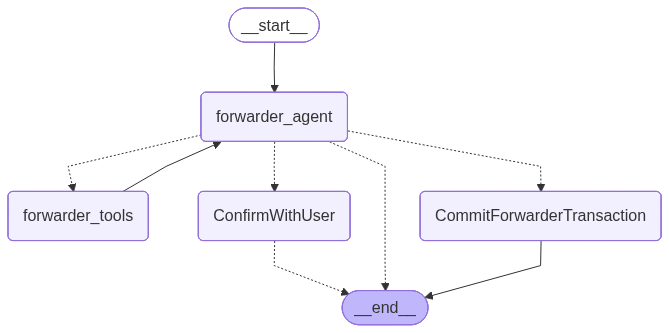

In [11]:
from IPython.display import Image, display
from src.forwarder_agent import ForwarderAgent

# Show the agent
display(Image(ForwarderAgent.get_graph(xray=True).draw_mermaid_png()))

In [12]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
from src.forwarder_agent import ForwarderAgent
thread = {"configurable":{"thread_id":"1"}}
message = "Shipment Readiness Date is 2025-09-30"
result = await ForwarderAgent.ainvoke({"agent_brief" : message,
                                        "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Information**                                                                              │
│                                                                                                                 │
│ I can't proceed with your Forwarder request because the following required field is missing:                    │
│                                                                                                                 │
│ - **Pick Up Date**: The actual date when the forwarder collects the cargo from the supplier’s premises          │
│ (factory/warehouse).                                                                                            │
│                                                                                                                 │
│ **Please provide the Pick Up Date** in your reply. If you need help or clarification, let me know!              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
message = "Shipment Readiness Date is 2025-09-30 and Pick up Date is 2025-08-30"
result = await ForwarderAgent.ainvoke({"agent_brief" : message,
                                        "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Information**                                                                              │
│                                                                                                                 │
│ I can't proceed with your Forwarder request because the following required field is missing:                    │
│                                                                                                                 │
│ - **Pick Up Date**: The actual date when the forwarder collects the cargo from the supplier’s premises          │
│ (factory/warehouse).                                                                                            │
│                                                                                                                 │
│ **Please provide the Pick Up Date** in your reply. If you need help or clarification, let me know!              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30 and Pick up Date is 2025-08-30                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30 and Pick up Date is 2025-08-30                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your request, which could help make your record more complete:            │
│                                                                                                                 │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country of Origin                                                                                             │
│ - Airport/Seaport Name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross Weight (KG)                                                                                             │
│ - CBM                                                                                                           │
│ - ETD                                                                                                           │
│ - Chargeable Weight (KG)                                                                                        │
│ - Freight Cost                                                                                                  │
│ - Total Value of Goods                                                                                          │
│ - Freight Invoice Number                                                                                        │
│ - ETA                                                                                                           │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ You can:                                                                                                        │
│ - Provide any of these details now (just reply with the field and value)                                        │
│ - Ask me to skip them and proceed                                                                               │
│ - Let me know if you’ll add them later                                                                          │
│                                                                                                                 │
│ How would you like to continue?                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
message = "Shipment Readiness Date is 2025-09-30, Pick Up Date is 2025-08-30. skip and proceed"
result = await ForwarderAgent.ainvoke({"agent_brief" : message,
                                        "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Information**                                                                              │
│                                                                                                                 │
│ I can't proceed with your Forwarder request because the following required field is missing:                    │
│                                                                                                                 │
│ - **Pick Up Date**: The actual date when the forwarder collects the cargo from the supplier’s premises          │
│ (factory/warehouse).                                                                                            │
│                                                                                                                 │
│ **Please provide the Pick Up Date** in your reply. If you need help or clarification, let me know!              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30 and Pick up Date is 2025-08-30                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30 and Pick up Date is 2025-08-30                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your request, which could help make your record more complete:            │
│                                                                                                                 │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country of Origin                                                                                             │
│ - Airport/Seaport Name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross Weight (KG)                                                                                             │
│ - CBM                                                                                                           │
│ - ETD                                                                                                           │
│ - Chargeable Weight (KG)                                                                                        │
│ - Freight Cost                                                                                                  │
│ - Total Value of Goods                                                                                          │
│ - Freight Invoice Number                                                                                        │
│ - ETA                                                                                                           │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ You can:                                                                                                        │
│ - Provide any of these details now (just reply with the field and value)                                        │
│ - Ask me to skip them and proceed                                                                               │
│ - Let me know if you’ll add them later                                                                          │
│                                                                                                                 │
│ How would you like to continue?                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30, Pick Up Date is 2025-08-30. skip and proceed                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Shipment Readiness Date is 2025-09-30, Pick Up Date is 2025-08-30. skip and proceed                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your request, which could help make your record more complete:            │
│                                                                                                                 │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country of Origin                                                                                             │
│ - Airport/Seaport Name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross Weight (KG)                                                                                             │
│ - CBM (Cubic Meter)                                                                                             │
│ - ETD (Estimated Time of Departure)                                                                             │
│ - Chargeable Weight (KG)                                                                                        │
│ - Freight Cost                                                                                                  │
│ - Total Value of Goods                                                                                          │
│ - Freight Invoice Number                                                                                        │
│ - ETA (Estimated Time of Arrival)                                                                               │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ You can provide any of these details now, skip them and proceed, or add them later.                             │
│ Please let me know how you’d like to continue!                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [15]:
message = "Shipment Readiness Date is 2025-09-30, Pick Up Date is 2025-08-30. skip and proceed. confirm"
result = await ForwarderAgent.ainvoke({"agent_brief" : message,
                                        "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

UnsupportedOperation: fileno

In [11]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
from src.forwarder_agent import ForwarderAgent
thread = {"configurable":{"thread_id":"2"}}
message = "Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a freight cost of $4,800."
result = await ForwarderAgent.ainvoke({"agent_brief" : message,
                                        "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also    │
│ Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a   │
│ freight cost of $4,800.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also    │
│ Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a   │
│ freight cost of $4,800.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your request, which could help make your record more complete:            │
│                                                                                                                 │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country of Origin                                                                                             │
│ - Airport/Seaport Name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross Weight (KG)                                                                                             │
│ - CBM (Cubic Meter)                                                                                             │
│ - ETA (Estimated Time of Arrival)                                                                               │
│ - Total Value of Goods                                                                                          │
│ - Freight Invoice Number                                                                                        │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ You can provide any of these details now, skip them and proceed, or add them later. Please let me know how      │
│ you’d like to continue.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
message = "Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a freight cost of $4,800. skip them and proceed"
result = await ForwarderAgent.ainvoke({"agent_brief" : message,
                                        "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also    │
│ Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a   │
│ freight cost of $4,800.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also    │
│ Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a   │
│ freight cost of $4,800.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your request, which could help make your record more complete:            │
│                                                                                                                 │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country of Origin                                                                                             │
│ - Airport/Seaport Name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross Weight (KG)                                                                                             │
│ - CBM (Cubic Meter)                                                                                             │
│ - ETA (Estimated Time of Arrival)                                                                               │
│ - Total Value of Goods                                                                                          │
│ - Freight Invoice Number                                                                                        │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ You can provide any of these details now, skip them and proceed, or add them later. Please let me know how      │
│ you’d like to continue.                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also    │
│ Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a   │
│ freight cost of $4,800. skip them and proceed                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also    │
│ Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a   │
│ freight cost of $4,800. skip them and proceed                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is the final list of fields for your confirmation:                                                         │
│                                                                                                                 │
│ - Shipment Readiness Date: 2025-03-05                                                                           │
│ - Pick Up Date: 2025-03-07                                                                                      │
│ - Chargable Weight (KG): 1250                                                                                   │
│ - Freight Cost: 4800                                                                                            │
│                                                                                                                 │
│ The following optional fields are still missing:                                                                │
│ - No. of Pallets                                                                                                │
│ - No. of Containers                                                                                             │
│ - Commodity Description                                                                                         │
│ - Country Of Origin                                                                                             │
│ - AirPort/SeaPort name                                                                                          │
│ - Shipping Line/Airline                                                                                         │
│ - Port Of Destination                                                                                           │
│ - Actual ATA - FF                                                                                               │
│ - Gross weight (KG)                                                                                             │
│ - CBM                                                                                                           │
│ - ETD: 2025-03-10                                                                                               │
│ - Total values of Goods                                                                                         │
│ - Freight Invoice Number                                                                                        │
│ - ETA                                                                                                           │
│ - Freight Comment                                                                                               │
│                                                                                                                 │
│ Please confirm if the above information is correct and if you wish to proceed.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
message = "Record that the cargo was ready on March 5, 2025, and collected from the supplier on March 7, 2025, and also Record that the shipment is scheduled to depart on March 10, 2025, with a chargeable weight of 1,250 KG and a freight cost of $4,800. skip them and proceed. confirm"
result = await ForwarderAgent.ainvoke({"agent_brief" : message,
                                        "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

UnsupportedOperation: fileno